[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BonnenLab/tracking-psychopy-bonnen-2015/blob/main/Tutorial.ipynb)

In [2]:
google_colab = False

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scipy
import numpy as np
import pandas as pd
import statsmodels.api as sm
!pip install pykalman
from pykalman import KalmanFilter
import torch
from torch import nn
%load_ext autoreload
%autoreload 2
import psignifit as ps
from tqdm import tqdm
import os

# IN GOOGLE COLAB uncomment the code below 
# import os
# user = "bonnenlab"
# repo = "tracking-psychopy-bonnen-2015"
# # remove local directory if it already exists
# if os.path.isdir(repo):
#     !rm -rf {repo}
# !git clone https://github.com/{user}/{repo}.git



import load



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Tracking

## A.1 Data Collection:
Let's collect a little bit of tracking data! 

### If you're at CSHL 2024, go here --> https://run.pavlovia.org/kbonnen/bonnen2015_tracking

### If you're at home after the course (or you don't know what I'm talking about):

1. Download psychopy: https://www.psychopy.org/download.html

2. Clone the tracking git repository from gitlab: 

```
git clone https://gitlab.pavlovia.org/kbonnen/bonnen2015_tracking.git
```
3. Open the bonnen2015_tracking.psyexp experiment in psychopy and hit the play button to run.


  ### Then ...
  Give yourself a participant ID (e.g., your initials, but nothing identifiable).  Collect a couple of blocks of data.  This will be saved in the gitlab repository.
   
   Once you've collected data, you can get the data here:

In [4]:
# Pull data from gitlab
if google_colab:
    data_file_tracking = 'bonnen2015_tracking/data/'
    !git -C bonnen2015_tracking pull
else:
    data_file_tracking = '../bonnen2015_tracking/data/'
    !git -C ../bonnen2015_tracking/data/ pull


From https://gitlab.pavlovia.org/kbonnen/bonnen2015_tracking
 * branch            master     -> FETCH_HEAD
Already up to date.


#### A.2 Data Visualization:
Let's visualize this data. 

In [5]:
# load the data

pid = '740813' # <--- put your subject id here
data_tracking = load.tracking_data(data_file_tracking,pid)
print(f'\nThere are {data_tracking.shape[0]} total trials.')


loading data files...
../bonnen2015_tracking/data/740813_Bonnen2015_tracking_2024-07-14_23h23.18.508.csv

There are 9 total trials.


##### Visualize individual trials - Like Figure 2 of Bonnen et al. 2015
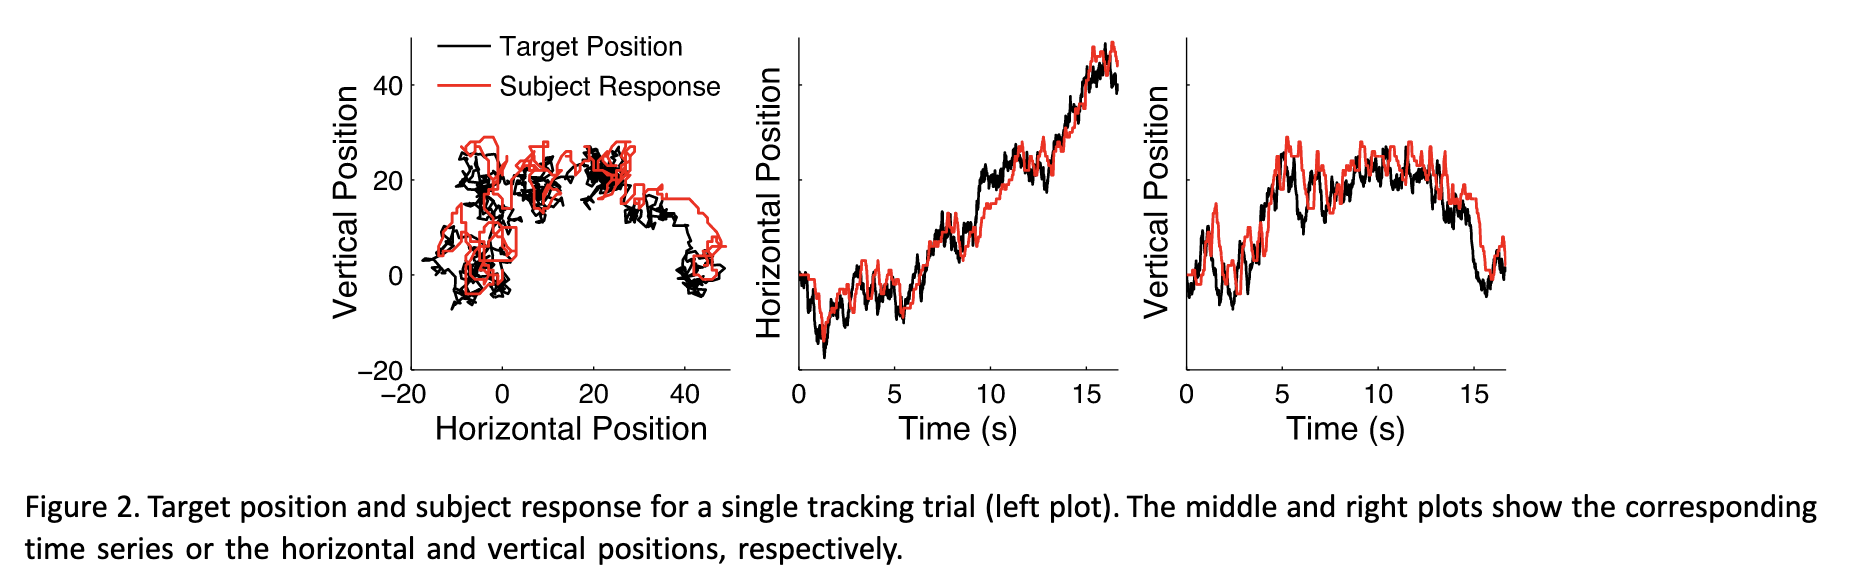

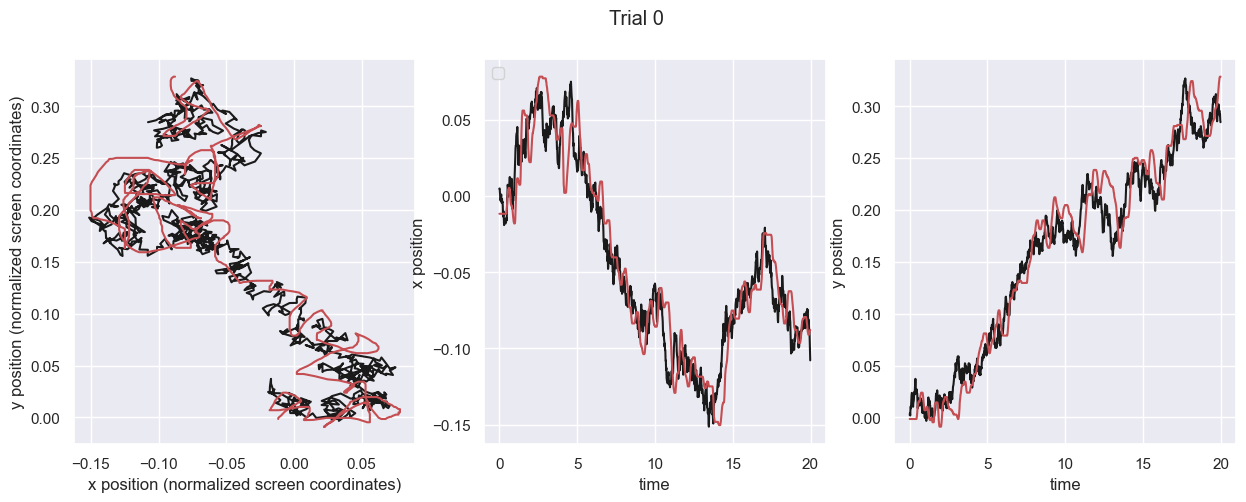

In [6]:
# Visualize a trial of your choice
trialNo = 0;

fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle(f'Trial {trialNo}')
data_tracking

axs[0].plot(data_tracking['target.x'][trialNo],data_tracking['target.y'][trialNo],'k')
axs[0].plot(data_tracking['mouse.x'][trialNo],data_tracking['mouse.y'][trialNo],'r')
axs[0].set_xlabel('x position (normalized screen coordinates)')
axs[0].set_ylabel('y position (normalized screen coordinates)');
axs[1].legend(['stimulus','response'], ncol=2, loc='upper left');

axs[1].plot(data_tracking.time[trialNo],data_tracking['target.x'][trialNo],'k')
axs[1].plot(data_tracking.time[trialNo],data_tracking['mouse.x'][trialNo],'r')
axs[1].set_xlabel('time')
axs[1].set_ylabel('x position')

axs[2].plot(data_tracking.time[trialNo],data_tracking['target.y'][trialNo],'k')
axs[2].plot(data_tracking.time[trialNo],data_tracking['mouse.y'][trialNo],'r')
axs[2].set_xlabel('time')
axs[2].set_ylabel('y position');

# Q: Can you add an offset to the data_tracking.response_time[trialNo] to figure out the time delay in the response?

#### A.3 Analyze your data!  --  Cross-correlograms

In [7]:
def cross_correlation(sig1,sig2):
    corr = sm.tsa.stattools.ccf(sig2, sig1)
    # Remove padding and reverse the order
    corr[0:(len(sig2)+1)][::-1] 
    return corr

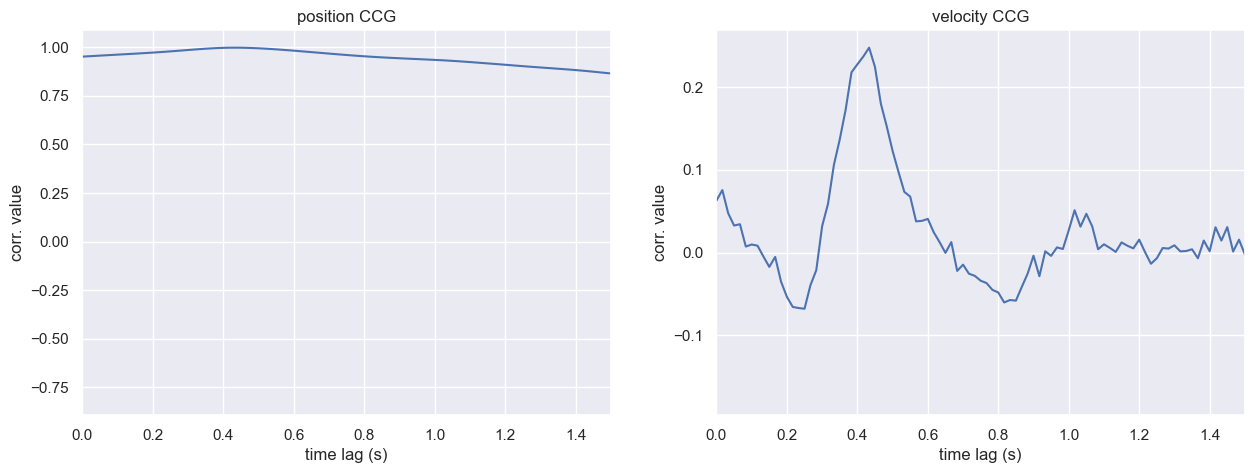

In [8]:
# Visualize a single CCG in position and/or velcity
trialNo = 0;
frameRate = 60;

stim = data_tracking['target.x'][trialNo]
response = data_tracking['mouse.x'][trialNo]
ccg = cross_correlation(stim,response)
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(np.arange(0,ccg.shape[0])/frameRate,ccg)
axs[0].set_xlabel('time lag (s)')
axs[0].set_ylabel('corr. value')
axs[0].set_title('position CCG')
axs[0].set_xlim(0,1.5)


# Visualize a single CCG in position
stim = data_tracking['target.x'][trialNo]
response = data_tracking['mouse.x'][trialNo]
ccg = cross_correlation(np.diff(stim),np.diff(response))

plt.plot(np.arange(0,ccg.shape[0])/frameRate,ccg)
plt.xlabel('time lag (s)')
plt.ylabel('corr. value')
plt.title('velocity CCG')
plt.xlim(0,1.5);


# Q1: How would you leverage one or both of these CCGs to calculate the response delay?
#     If you're feeling adventurous, try writing some code to extract that value from one or both ccgs
#     hint: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

# Q2: What's the relationship between this example of continuous psychophysics and reverse correlation?

In [9]:
# Calculate velocity CCGs for every trial
nTrials = data_tracking.shape[0]

# Perform a cross correlation for each trial
ccg_x = [cross_correlation(np.diff(data_tracking['target.x'][tt]),np.diff(data_tracking['mouse.x'][tt])) for tt in range(0,nTrials)]
ccg_y = [cross_correlation(np.diff(data_tracking['target.y'][tt]),np.diff(data_tracking['mouse.y'][tt])) for tt in range(0,nTrials)]

# Save the CCGs
data_tracking['CCG_x'] = ccg_x
data_tracking['CCG_y'] = ccg_y

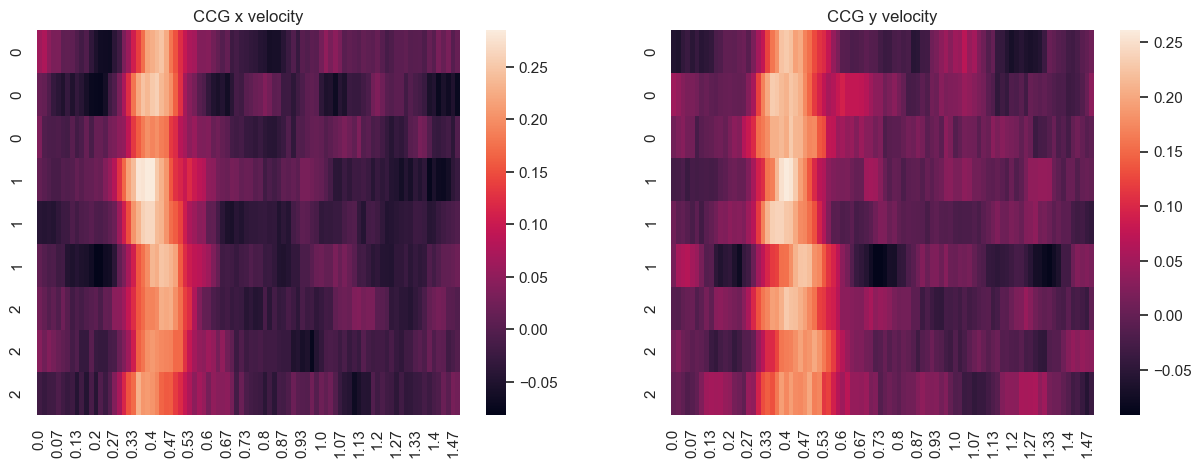

In [10]:
# Visualize the velocity CCGs for X and Y sorted by blobWidth
data_tracking=data_tracking.sort_values('condition')

# Put the data in a format that the heat maps are comfortable with
CCG_x = pd.DataFrame(np.stack(ccg_x)[:,:90],columns = data_tracking.time[0][:90].round(2), index=data_tracking.condition.to_numpy())
CCG_y = pd.DataFrame(np.stack(ccg_y)[:,:90],columns = data_tracking.time[0][:90].round(2), index=data_tracking.condition.to_numpy())

# Plot the data
fig, axs = plt.subplots(1,2,figsize=(15,5))
sns.heatmap(CCG_x,ax=axs[0])
axs[0].set_title('CCG x velocity')
sns.heatmap(CCG_y,ax=axs[1])
axs[1].set_title('CCG y velocity');

Text(0.5, 1.0, 'CCGs y by blob width')

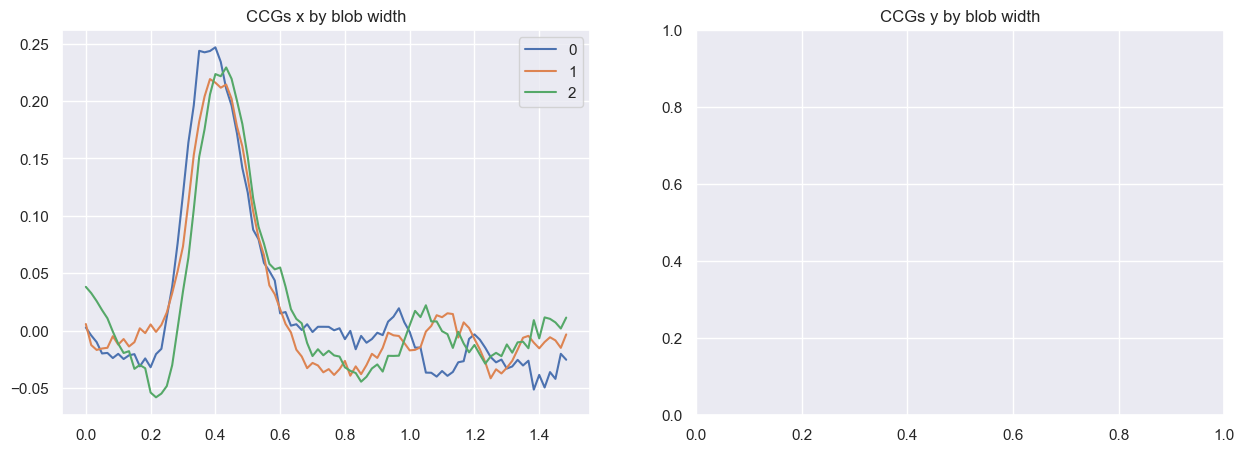

In [11]:
# Plot the data

fig, axs = plt.subplots(1,2,figsize=(15,5))

widths = [0,1,2]
for ww in widths:
    ccg = data_tracking.CCG_x[data_tracking.condition==ww].mean()
    axs[0].plot(np.arange(0,90)/60,ccg[:90])
    

axs[0].set_title('CCGs x by blob width')
axs[0].legend(widths, ncol=1, loc='upper right');
axs[1].set_title('CCGs y by blob width')


# Q: Try plotting y too!

## PAUSE HERE

#### A.3 Analyze your data!  -- Kalman Filter

Ok but first let's play a little with the Kalman filter... to figure out what's going on.

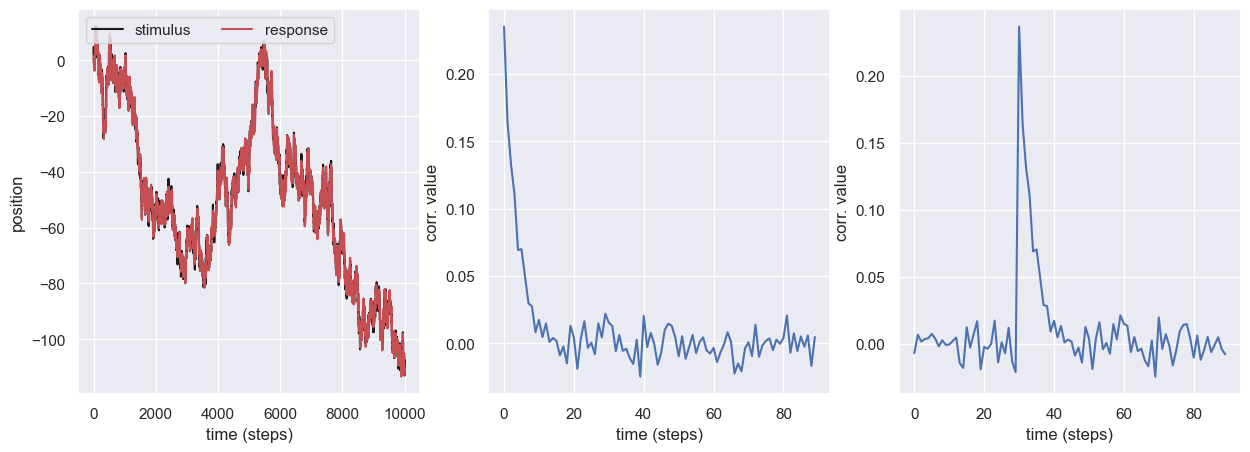

In [12]:
# simulate from a simple kalman filter
Q = 1
R = 15
N = 10000
ww = np.random.normal(0, np.sqrt(Q), (1,N))
x = ww.cumsum()
vv = np.random.normal(0,np.sqrt(R),(1,N))
measurements = x + vv

kf = KalmanFilter(
    transition_matrices = [1], 
    observation_matrices = [1], 
    transition_covariance = Q,
    observation_covariance = R)

xhat, _ = kf.filter(measurements)

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(x,'k')
axs[0].plot(xhat,'r')
axs[0].set_xlabel('time (steps)')
axs[0].set_ylabel('position');
axs[0].legend(['stimulus','response'], ncol=2, loc='upper left');


# You'll notice that this doesn't really match human CCGs...
ccg = cross_correlation(np.diff(x),np.diff(xhat.squeeze()))
axs[1].plot(ccg[:90])
axs[1].set_xlabel('time (steps)')
axs[1].set_ylabel('corr. value');

# Try calculating a ccg with a relative delay to the response
n=30
ccg2 = cross_correlation(np.diff(x[n:]),np.diff(xhat[:-n].squeeze()))
axs[2].plot(ccg2[:90])
axs[2].set_xlabel('time (steps)')
axs[2].set_ylabel('corr. value');

# Q1: What happens as you increase the number of time steps in the data (N)?

# Q2: What happens as you increase/decrease observation variance (R)?

In [49]:
# Helper functions for Kalman filter fitting

def simulate(Q,R,nSamples,nTrials):
    kf = KalmanFilter(
        transition_matrices = [1], 
        observation_matrices = [1], 
        transition_covariance = Q,
        observation_covariance = R)
    
    responses=[]
    stimuli = []
    for i in range(nTrials):
        ww = np.random.normal(0, np.sqrt(Q),nSamples)
        x = ww.cumsum()
        vv = np.random.normal(0,np.sqrt(R),nSamples)
        measurements = x + vv
        xhat, _ = kf.filter(measurements)
        responses.append(xhat.squeeze())
        stimuli.append(x)
    
    
    Xhat = np.stack(responses,axis=1)
    X = np.stack(stimuli,axis=1)
    
    return X,Xhat

def negLogLikelihoodr(rr,Q,X,Xhat):
    
    numTrials = X.shape[1]          # number of trials
    N = X.shape[0]                  # number of samples
    nLL = 0            
#     rr = torch.exp(rr)                 # exponentiate observation noise variance                  
    
    pp = Q/2 * (torch.sqrt(1+4*rr/Q)-1)   # posterior variance - Eq B8
    k = (pp+Q)/(pp+Q+rr)         # Kalman Gain - eq B10
    d = torch.diag(torch.ones(N),0)+torch.diag((k-1)*torch.ones(N-1),-1);    # Eq B12
    # I'm going to have to implement this manually :(
    
    #  NOTE: The appendix describes maximum likelihood fitting of R using 
    #  p(xhat|x) (see Equation B14).  It is simpler (and significantly faster
    #  for the MATLAB implementation) to maximize the likelihood that 
    #  (D*xhat - K*x) ~ N(0,K^2*R)

    for i in range(numTrials):
        x = X[:,i];
        xhat = Xhat[:,i];
        temp = torch.matmul(d,xhat) - (k*x); # eq B11
        nLL -=  (-1/(2*k**2*rr)*torch.matmul(temp.T,temp) - N/2*torch.log(rr) - N*torch.log(k)); # the negative log likelihood that (D*xhat - K*x) ~ N(0,K^2*R) 
              
    return nLL


def estimateR(Q,X,Xhat,possibleR):
    # the torch optimization is behaving a bit oddly... 
    # Since it's a single parameter optimization, let's use a grid-search.  
    # Makes the whole thing more transparent anyways

    nLL = torch.empty_like(possibleR)

    for ii in tqdm(range(possibleR.shape[0])):
        nLL[ii] = negLogLikelihoodr(possibleR[ii],Q,torch.tensor(X,dtype=torch.float),torch.tensor(Xhat,dtype=torch.float))

    idx = np.argmin(nLL)
    return possibleR[idx]

In [75]:
# Do a simulation to verify that we can extract the value R
Q = torch.tensor(1);
R = torch.tensor(100);
possibleR = torch.arange(20,150,.1)
nSamples = 1200
nTrials = 30
X,Xhat = simulate(Q,R,nSamples,nTrials)
estimated_R = estimateR(Q,X,Xhat,possibleR)
print(estimated_R)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:03<00:00, 331.48it/s]

tensor(100.3000)


In [85]:
widths = [0,1,2]
possibleR = torch.arange(.0001,.001,.0001)
for ww in widths:   
    this_condition = data_tracking[data_tracking.condition==ww]
    target_X = np.stack(this_condition['target.x'].values).T
    response_X = np.stack(this_condition['mouse.x'].values).T
    Q = np.std(np.diff(data_X,axis=0))
    rr = estimateR(Q,target_X,response_X,possibleR)
    print(rr)
#     estimated_R = estimateR()
# this_condition




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 602.37it/s]


tensor(0.0004)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 718.67it/s]


tensor(0.0005)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 777.54it/s]

tensor(0.0007)


### Note: This is not the original implementation (it was in MATLAB :dinosaur: )

If you're curious to about the details of the math or want to see the original implementation, I recommend having a look at the [appendix](https://pillowlab.princeton.edu/pubs/Bonnen15_JOV_kalmantracking.pdf) and exploring the [matlab implementation](https://github.com/kbonnen/BonnenEtAl2015_KalmanFilterCode) of Kalman filter fitting on github.

The code has comments showing you where it matches up with the appendix.

## B. Comparable measurement of visual sensitivity using 2AFC

Run from an installation of psychopy: [https://www.psychopy.org/download.html](https://www.psychopy.org/download.html)

You'll need to load the experiment in the `PsychopyRunner` window by selecting the blue `+` and navigating to the experiments/tracking file and loading the Bonnen2015_2afc.psyexp.

Give yourself a participant ID (e.g., your initials).  Collect a couple of blocks of data.  This will be saved in `./experiment/2afc/data`.

In [12]:
# load 2afc data
data_file_2afc = 'data/' 
pid = '479379' #'824981' #'161589'
data_2afc = load.twoAFC_data(data_file_2afc,pid)
print(f'\nThere are {data_2afc.shape[0]} total trials.')


data_2afc

loading data files...
data/479379_Bonnen2015_2afc_2024-07-14_11h26.51.985.csv

There are 195 total trials.


,key_resp.keys,key_resp.rt,offset,imageFile,participant,session,condition
0,left,0.199,-0.0025,images/blob-medium.jpg,479379,1,1
1,left,0.292,-0.0075,images/blob-big.jpg,479379,1,2
2,left,0.334,-0.0075,images/blob-medium.jpg,479379,1,1
3,left,0.282,-0.0100,images/blob-big.jpg,479379,1,2
4,left,0.145,-0.0075,images/blob.jpg,479379,1,0
...,...,...,...,...,...,...,...
194,left,0.271,-0.0250,images/blob-big.jpg,479379,1,2
195,left,0.233,-0.0100,images/blob-medium.jpg,479379,1,1
196,right,0.178,0.0100,images/blob.jpg,479379,1,0
197,right,0.408,0.0075,images/blob-big.jpg,479379,1,2


In [13]:
# Prepare to visualize psychometric function
data_2afc['chose_right'] = data_2afc['key_resp.keys'] == 'right'

# count the total number of trials and the number chose right
p_data = data_2afc.groupby(['offset','condition'],as_index = False)['chose_right'].agg(['sum','count'])
condition = p_data.condition
p_data=p_data[['offset','sum','count']]

(array([], dtype=int64),)


/Users/kbonnen/Documents/work-repos/python-psignifit/psignifit/likelihood.py:191: RuntimeWarning: divide by zero encountered in log
  pbin = pbin  + (ni-ki)*np.log(1-psi)
/Users/kbonnen/Documents/work-repos/python-psignifit/psignifit/likelihood.py:121: RuntimeWarning: divide by zero encountered in log
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/Users/kbonnen/Documents/work-repos/python-psignifit/psignifit/likelihood.py:121: RuntimeWarning: invalid value encountered in multiply
  p = p + k * np.log(psi) + (n-k)*np.log(1-psi)   # binomial model
/Users/kbonnen/Documents/work-repos/python-psignifit/psignifit/likelihood.py:127: RuntimeWarning: invalid value encountered in subtract
  p = p -sp.gammaln(n+v) - sp.gammaln(a) - sp.gammaln(b)


(array([], dtype=int64),)
(array([], dtype=int64),)


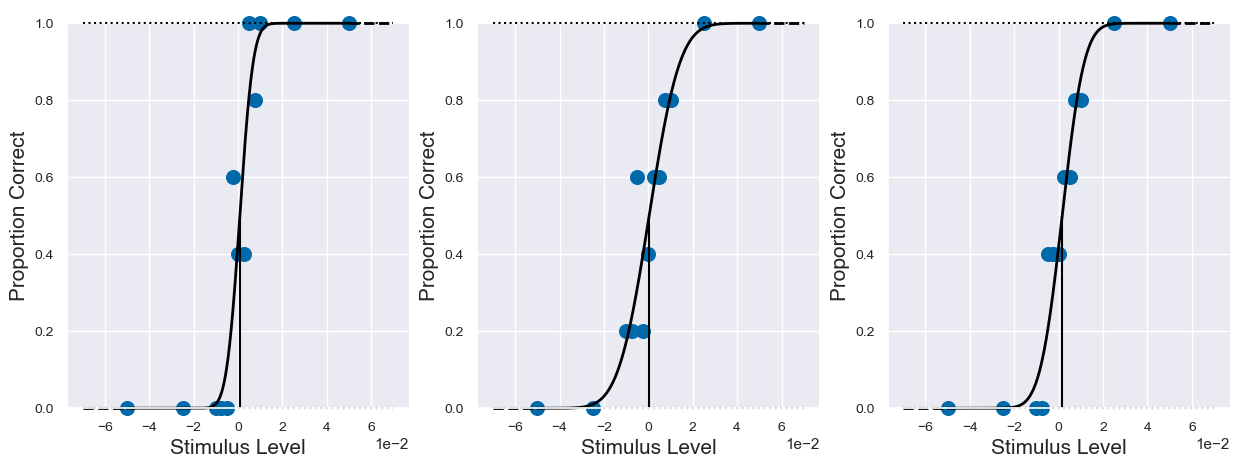

In [14]:
# Left as an exercise to visualize and fit psychometric functions to these data
# I strongly recommend psignifit for both visualize and fitting: https://github.com/wichmann-lab/psignifit

options                = dict()   # initialize as an empty dict
options['sigmoidName'] = 'norm'   # choose a cumulative Gauss as the sigmoid
options['expType']     = 'YesNo'   # choose 2-AFC as the paradigm of the experiment
                                  # this sets the guessing rate to .5 and
                                  # fits the rest of the parameters '''

fig,ax = plt.subplots(1,3,figsize=(15,5))
results = [[]]*3
for ii in range(3):
    p_data_np = (p_data.values[condition==ii])
    p_data_np
    results[ii] = ps.psignifit(p_data_np, options)
    ps.psigniplot.plotPsych(results[ii],axisHandle=ax[ii],showImediate=False)
    
plt.show()

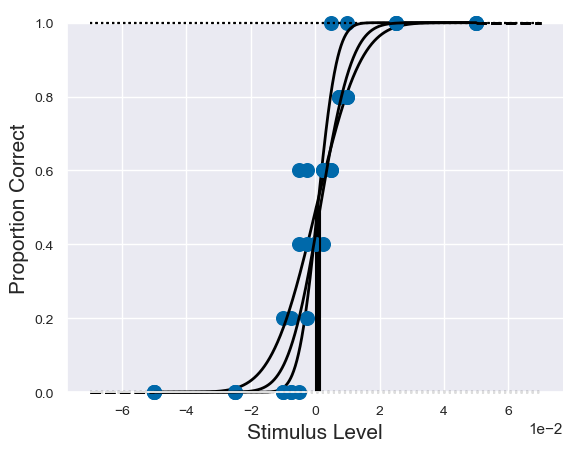

In [15]:
fig = plt.figure()
for ii in range(3):
    ps.psigniplot.plotPsych(results[ii],axisHandle=plt.gca(),showImediate=False)
    
plt.show()

# todo colors + legends

0.0037884222266529183


(array([ 147.,  539., 1032., 1633., 2025., 1952., 1616., 1088.,  564.,
         195.]),
 array([-9.79637856e-03, -7.84863345e-03, -5.90088835e-03, -3.95314325e-03,
        -2.00539814e-03, -5.76530421e-05,  1.89009206e-03,  3.83783716e-03,
         5.78558227e-03,  7.73332737e-03,  9.68107247e-03]),
 <BarContainer object of 10 artists>)

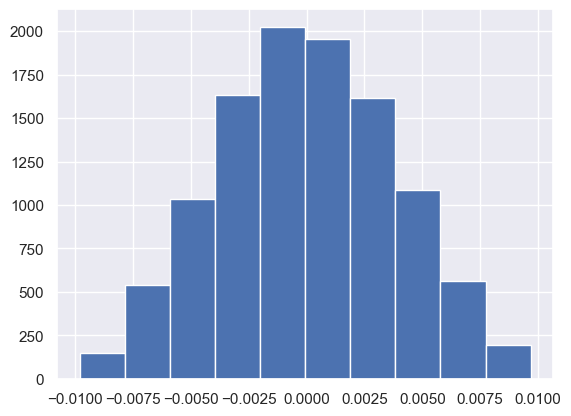

In [19]:
# CONSTRUCTION

data_X = np.stack(data_tracking['target.x'].values).T
# plt.plot(np.diff(data_X,axis=0))
std = np.std(np.diff(data_X,axis=0))
std
print(std)
plt.hist(np.diff(data_X,axis=0).flatten())